In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from gaia_spec import *
import glob

In [2]:
bps = lsst_filters()
bps.update(stubb_fitlers())

In [3]:
rf = glob.glob('*response*00.npz')
responses = []
teffs = []
for filename in rf:
    responses.append(gaia_response(restore_file=filename))
    teffs.append(filename.replace('.npz', '').split('_')[-1])
# response = gaia_response(restore_file='gaia_response_nonoise.npz')

(0, 5e-16)

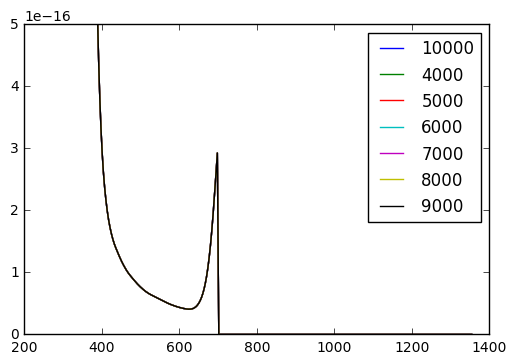

In [4]:
dir(responses[0])
for response,teff in zip(responses, teffs):
    plt.plot(response.blue_wavelen, response.blue_response, label='%s' % teff)
plt.legend()
plt.ylim([0,5e-16])

In [5]:
responses[0].red_response-responses[4].red_response

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [18]:
input_mag = 18
sed = Sed()
# Read in an SED that's solar-like, set to g=16, don't bother adding dust.
sed.read_close_SED(15000., 0., 4.4)
fNorm = sed.calcFluxNorm(input_mag, bps['g'])
sed.multiplyFluxNorm(fNorm)

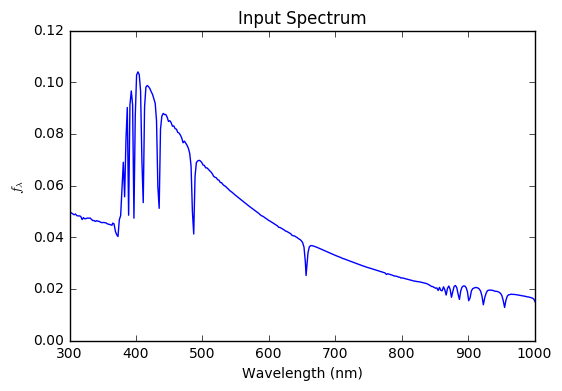

In [19]:
plt.plot(sed.wavelen, sed.flambda*5.03e8*sed.wavelen*100)
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$f_\lambda$ ')
plt.xlim([300,1000])
plt.title('Input Spectrum')

In [20]:
workdir = 'plot_work'
gaia_observed = SED2GAIA(sed, workdir=workdir)


In [21]:
observed_sed = ulysses2SED(data=gaia_observed, response=response)
not_nan = ~np.isnan(observed_sed.flambda)
observed_sed.flambda = np.interp(observed_sed.wavelen, observed_sed.wavelen[not_nan],
                                             observed_sed.flambda[not_nan])

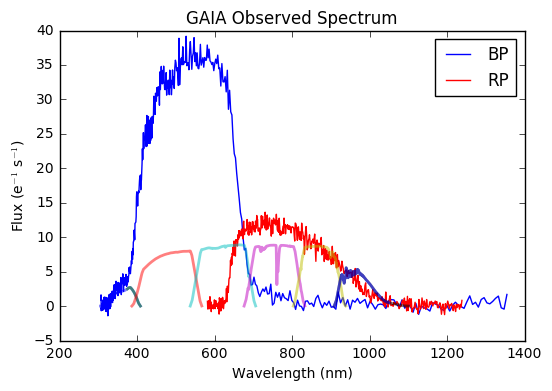

In [22]:
plt.plot(gaia_observed['BP_wave'], gaia_observed['noisySpec'][0]['BPNoisySpec'], 'b', label='BP')
plt.plot(gaia_observed['RP_wave'], gaia_observed['noisySpec'][0]['RPNoisySpec'], 'r', label='RP')
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'Flux (e$^{-1}$ s$^{-1}$)')
plt.title('GAIA Observed Spectrum')
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*gaia_observed['noisySpec'][0]['BPNoisySpec'].max()*.5, alpha=.5, linewidth=2)
 

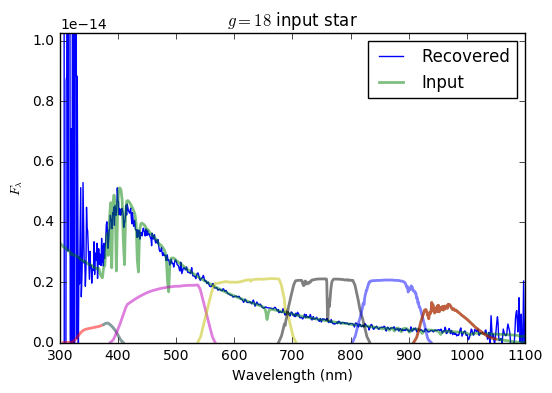

In [23]:
plt.plot(observed_sed.wavelen, observed_sed.flambda, label='Recovered')
plt.plot(sed.wavelen, sed.flambda, label='Input', linewidth=2, alpha=.5)
plt.legend()
plt.xlabel('Wavelength (nm)')
plt.ylabel(r'$F_\lambda$')
plt.xlim([300,1100])
plt.title(r'$g=%.0f$ input star' % input_mag)
plt.ylim([0,sed.flambda.max()*1.1])
filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
for fn in filters:
    plt.plot(bps[fn].wavelen, bps[fn].sb*sed.flambda.max()*.5, alpha=.5, linewidth=2)
    

In [12]:

print 'filter, input, recovered, diff (mmag)'
for fn in filters:
    inmag = sed.calcMag(bps[fn])
    outmag = observed_sed.calcMag(bps[fn])
    print '%s, %.2f, %.2f, %f' % (fn, inmag, outmag, (inmag-outmag)*1e3)

filter, input, recovered, diff (mmag)
u, 19.03, nan, nan
u_truncated, 18.60, 18.55, 42.287801
g, 18.00, 18.00, 2.478991
r, 17.70, 17.72, -17.152622
i, 17.62, 17.63, -7.003789
z, 17.61, 17.62, -11.739935
y, 17.61, 17.59, 13.306601
y_truncated, 17.60, 17.59, 12.753795


/Users/yoachim/gitRepos/sims_photutils/python/lsst/sims/photUtils/Sed.py:800: UserWarning: There is an area of non-overlap between desired wavelength range (305.40 to 408.50) and sed FromArray (306.64 to 1239)
  % (wavelen_grid.min(), wavelen_grid.max(), self.name, wavelen.min(), wavelen.max()))


In [13]:
def star2mags(teff, feH, logg, response=None, work_dir='temp_work'):
    # Let's see if I can understand the crazy shift with temperature
    filters = ['u', 'u_truncated', 'g', 'r', 'i', 'z', 'y', 'y_truncated']
    sed.read_close_SED(6000., 0., 4.4)
    fNorm = sed.calcFluxNorm(input_mag, bps['g'])
    sed.multiplyFluxNorm(fNorm)
    gaia_observed = SED2GAIA(sed, workdir=workdir)
    observed_sed = ulysses2SED(data=gaia_observed, response=response)
    not_nan = ~np.isnan(observed_sed.flambda)
    observed_sed.flambda = np.interp(observed_sed.wavelen, observed_sed.wavelen[not_nan],
                                                 observed_sed.flambda[not_nan])
    inmags = []
    outmags = []
    for fn in filters:
        inmags.append(sed.calcMag(bps[fn]))
        outmags.append(observed_sed.calcMag(bps[fn]))
    return (inmags, outmags)


In [14]:
hotin, hotout = star2mags(10000, 0, 4.4, response=response)
coldin, coldout = star2mags(1000, 0, 3., response=response)

In [15]:
hotin, hotout

([19.033972456767835,
  18.595560365701772,
  18.0,
  17.70431707629827,
  17.622193625342682,
  17.60947082993718,
  17.605474906946615,
  17.604910760073331],
 [nan,
  18.557346115100941,
  17.995146210094113,
  17.7189437358352,
  17.623803983680439,
  17.613932239641642,
  17.57473345626796,
  17.569760656964824])